In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [35]:
Data_Table = pd.read_csv('./seqData_1e6_16k3wheel_BMR441.dat',header=None)

In [36]:
Data = (Data_Table.values).astype('float32')

In [4]:
Data[:,0:16] = Data[:,0:16]/np.max(Data[:,0:16])
Data[:,16] = (Data[:,16]-1e6)/(np.max(Data[:,16])-1e6)

In [37]:
print(np.max(Data[:,0:16]),np.max(Data[:,16]))

342.0 2224128.0


# Neural network

In [6]:
def weight_variable(shape):
	initial = tf.truncated_normal(shape, stddev=0.2)
	return tf.Variable(initial)

def bias_variable(shape):
	initial = tf.constant(0.01, shape=shape)
	return tf.Variable(initial)

In [7]:
# Input
in_Size = 16
Input = tf.placeholder(tf.float32, [1,in_Size])

# Neural Network
# -------------------- hidden layer #1 -------------------- #
hidden_unit1 = 32
lamb1 = 1e-2 # regulizer
W_fc1 = weight_variable([in_Size, hidden_unit1])
b_fc1 = bias_variable([hidden_unit1])

h_fc1 = tf.nn.tanh(tf.matmul(Input, W_fc1) + b_fc1)

# -------------------- hidden layer #2 -------------------- #
hidden_unit2 = 64
lamb2 = 1e-2 # regulizer
W_fc2 = weight_variable([hidden_unit1, hidden_unit2])
b_fc2 = bias_variable([hidden_unit2])

h_fc2 = tf.nn.tanh(tf.matmul(h_fc1, W_fc2) + b_fc2)


# --------------------- Output layer ---------------------- #
Out_Unit = 1
lambO = 1e-2 # regulizer
W_fcO = weight_variable([hidden_unit2, Out_Unit])
b_fcO = bias_variable([Out_Unit])

y_out = 1.0/(tf.exp(-tf.matmul(h_fc2, W_fcO) - b_fcO\
                - lambO*tf.nn.l2_loss(W_fcO)\
                - lambO*tf.nn.l2_loss(b_fcO))+1.0)

# ----------------------- Loss ---------------------------- #
y_ref = tf.placeholder(tf.float32, 1, name='y_out')
Err = tf.abs(tf.subtract(y_out,y_ref))


In [8]:
# Optimizer
Loss = tf.square(tf.subtract(y_out,y_ref))
optim = tf.train.AdamOptimizer(1e-3).minimize(Loss)

# Test

In [9]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [10]:
init = tf.global_variables_initializer()
sess.run(init)

In [11]:
Num_Epoch = 20

In [12]:
Training_Len = 50000

In [13]:
Size_perEpoch = 1000

for epoch in range(Num_Epoch):
    # Use the first 15 days for training
    # batch of 500 per epoch
    ERR = 0.0
    Training_Tar = np.random.choice(range(Training_Len),Size_perEpoch)
    for i in Training_Tar:
        in_x = Data[i,0:16].reshape([1,in_Size])
        tar_y = [Data[i,16]]
        sess.run(optim,feed_dict={Input: in_x,
                                  y_ref: tar_y})
        
        Test_At = i+50000
        in_x = Data[Test_At,0:16].reshape([1,in_Size])
        tar_y = [Data[Test_At,16]]
        ERR += sess.run(Err,feed_dict={Input: in_x,
                                       y_ref: tar_y})
    
    Err_Message = ' %.3e'%(ERR/Size_perEpoch)
    print('After epoch #%i'%epoch, Err_Message)

After epoch #0  6.011e-02
After epoch #1  5.303e-02
After epoch #2  4.934e-02
After epoch #3  4.850e-02
After epoch #4  4.778e-02
After epoch #5  4.806e-02
After epoch #6  4.836e-02
After epoch #7  5.042e-02
After epoch #8  4.557e-02
After epoch #9  4.887e-02
After epoch #10  4.893e-02
After epoch #11  4.687e-02
After epoch #12  4.826e-02
After epoch #13  4.593e-02
After epoch #14  4.950e-02
After epoch #15  4.798e-02
After epoch #16  4.816e-02
After epoch #17  4.682e-02
After epoch #18  5.075e-02
After epoch #19  4.922e-02


In [14]:
#saver = tf.train.Saver()

In [15]:
#saver.save(sess,'./Model/model16k3wheel_50.ckpt')

# Test

In [16]:
import csv
from copy import copy

In [17]:
P = 16

In [18]:
def get_BAMMA(filepath, rank_map = None):
    global P
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
    
    Algorithm = {}
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        if line[0][0] == '@':         # @ node
            rank = rank_map[(int)(line[0][1:])]
            Algorithm[rank] = []   # add node
            i = 1
            while i < len(line):
                if line[i] == 'C': # Compute
                    Vol = (int)(line[i+1])*\
                          (int)(line[i+2])*\
                          (int)(line[i+3])
                    Algorithm[rank].append(('C',Vol))
                    i += 3
                elif line[i] == 'S': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('S',rank_map[(int)(line[i+1])],Area))
                    i += 3
                elif line[i] == 'R': # Compute
                    Area = (int)(line[i+2])*(int)(line[i+3])
                    Algorithm[rank].append(('R',rank_map[(int)(line[i+1])],Area))
                    i += 3
                    
                    
                i += 1
    F.close()            
    return Algorithm

In [19]:
def Route_On_Static(Sender,Reciever,RTable,status,area):
    Act_to_Add = {p:[] for p in range(len(status))}
    Route = RTable[(Sender,Reciever)]
    
    # Sequencial
    prev = Sender
    for p in Route:
        # Waiting Time
        # update status
        if status[p] > status[prev]:
            Act_to_Add[prev].append(('W',status[p]-status[prev]))
            status[prev] = status[p]
        elif status[p] < status[prev]:
            Act_to_Add[p].append(('W',status[prev]-status[p]))
            status[p] = status[prev]
        
        # Comm Time
        Act_to_Add[prev].append(('S',area))
        Act_to_Add[p].append(('R',area))
        status[p] += area
        status[prev] += area
        
        # next pair
        prev = copy(p)

    return Act_to_Add

In [20]:
def Real_Routine(Raw_Route,Adj_M):
    # get num of actions vs each node
    Total_P = len(Raw_Route)

    lengths = np.zeros(Total_P,dtype='int32')

    for r,line in Raw_Route.items():
        lengths[r] = len(line)

    # Result
    Routine = {i:[] for i in range(Total_P)}
    # Nodes Status
    # 0:idle >0:length of queue
    Status = np.zeros(Total_P,dtype='int64')
    
        
    # BFS
    p = 0
    process = np.zeros(Total_P,dtype='int32')
    while True:
        # Finished
        if np.max(np.abs(lengths-process)) == 0:
            return Routine
        # finished nodes
        if lengths[p] == process[p]:
            p = (p+1)%Total_P
            continue
        
        Action = Raw_Route[p][process[p]]
        
        # overhead
        global SRTable
        Status -= np.min(Status)  # processing

        if Action[0] == 'C':      # Computation
            Routine[p].append(Action)
            # add queue
            Status[p] += Action[-1]
        elif Action[0] == 'S':    # Send
            Acts = Route_On_Static(p,Action[1],SRTable,Status,Action[-1])

            for pp,act in Acts.items():
                Routine[pp] += act
            
        #elif Action[0] == 'R':    # Recieve
        #    pass # done by sender
            
        
        
        # Update
        process[p] += 1
        p = (p+1)%Total_P
   
    return Routine

In [21]:
def get_Longest(Routes):
    Total_P = len(Routes)
    x_max = 0
    for p in range(Total_P):
        m_xmax = 0
        for act in Routes[p]:
            m_xmax += act[1]
        if m_xmax > x_max:
            x_max = m_xmax
    return x_max

In [22]:
def Get_Saturability_Seq(Route_Tensor, Comm_M, MAP):
    global P
    Ser = np.zeros(P,dtype='int16')
    i = 0
    for z in range(P):
        Ser[MAP[i]] = np.sum(Route_Tensor[:,:,z]*Comm_M)
        i += 1
    return Ser

In [23]:
def get_RoutineTensor(file_path):
    global P
    Tensor = np.zeros([P,P,P],dtype = 'int16')
    F = open(file_path,'r')
    FC = csv.reader(F)
    Table = {}
    
    for line in FC:
        l,r = line[0].split('|')
        ind = 1
        for ele in line[2:]:
            Tensor[(int)(l)][(int)(r)][(int)(ele)] = ind
            ind += 1
    
    F.close()
    
    return Tensor

In [24]:
def switch_nodes(M,_Map = None):
    if not _Map:
        _Map = {i:i for i in range(M.shape[0])}
    Res = copy(M)
    for src,to in _Map.items():
        Res[to,:] = M[src,:]
    Res1 = copy(Res)
    for src,to in _Map.items():
        Res1[:,to] = Res[:,src]
    return Res1

In [25]:
Routint_Tensor = get_RoutineTensor('topology/16k3wheel_Static.srt')

In [26]:
def Extract_cycles(filepath, rank_map = None):
    global P
    
    if rank_map == None:
        rank_map = {i:i for i in range(P)}
        
    Ideal = np.zeros([P,P],dtype='int16')
    F = open(filepath,'r')
    FC = csv.reader(F)
    for line in FC:
        At = rank_map[(int)(line[0][1:])]
        ind = 1
        for ele in line[1:]:
            if ele == 'S':
                Ideal[At][rank_map[(int)(line[ind+1])]] += 1
                Ideal[rank_map[(int)(line[ind+1])]][At] += 1
            ind += 1
            
    return Ideal

In [27]:
Unmap_Routine = Extract_cycles('BAMMA/P16_Fox441.csv')

In [28]:
def Get_ADJ(file_path):
    F = pd.read_csv(file_path, delimiter = ' ', header = None)
    return (F.values).astype('float32')

def Get_Static_Table(file_path):
    F = open(file_path,'r')
    FC = csv.reader(F)
    Table = {}
    
    for line in FC:
        l,r = line[0].split('|')
        seq = []
        for ele in line[2:]:
            seq.append((int)(ele))
            
        Table[((int)(l),(int)(r))] = seq
    
    F.close()
    
    return Table

In [29]:
Target_Topology = '16k3wheel'

Adj = Get_ADJ('topology/%s.adj'%Target_Topology)
SRTable = Get_Static_Table('topology/%s_Static.srt'%Target_Topology)

In [46]:
Test_D = []
TT = 0
for T in range(50):
    rand_series = np.random.permutation(np.arange(P))
    random_map = {i:rand_series[i] for i in range(P)}
    #random_map = Shuffle_with_Center(Center,Leaf)
    New_M = switch_nodes(Unmap_Routine,random_map)
    Ser = Get_Saturability_Seq(Routint_Tensor,New_M,random_map)
    T_Routine = get_BAMMA('BAMMA/P16_Fox441.csv',rank_map=random_map)
    m_time = get_Longest(Real_Routine(T_Routine,Adj))
    
    pred = sess.run(y_out,feed_dict = {
        Input:[Ser/342.0]
    })
    Test_D.append((Ser,pred,m_time))
    if T > TT + 99:
        print(T)
        TT = T

In [32]:
from matplotlib import pyplot as plt

In [47]:
XY = []
for d in Test_D:
    XY.append([d[1][0][0],d[2]])
XY = np.array(XY)

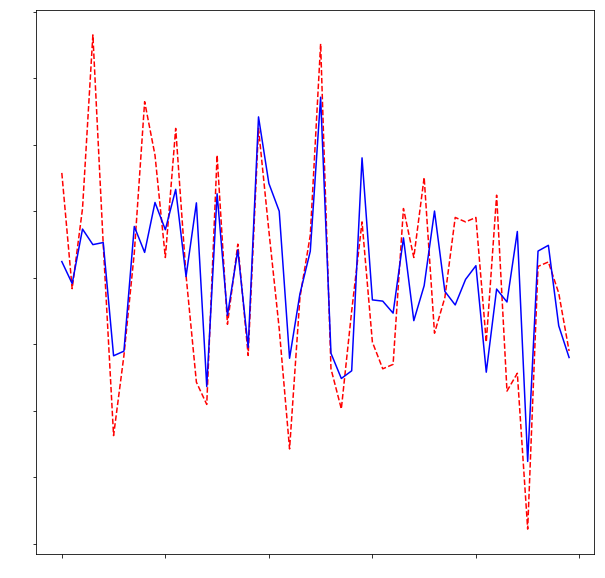

In [49]:
fig1 = plt.figure(figsize=[10,10])


plt.plot(np.arange(len(Test_D)),(XY[:,1]-1e6)/(2224128.0-1e6),'r--')
plt.plot(np.arange(len(Test_D)),XY[:,0],'b-')

plt.xticks(color='white')
plt.yticks(color='white')
plt.show()